<a href="https://colab.research.google.com/github/sju5079/QOSF_Mentorship/blob/main/QOSF_Cohort10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

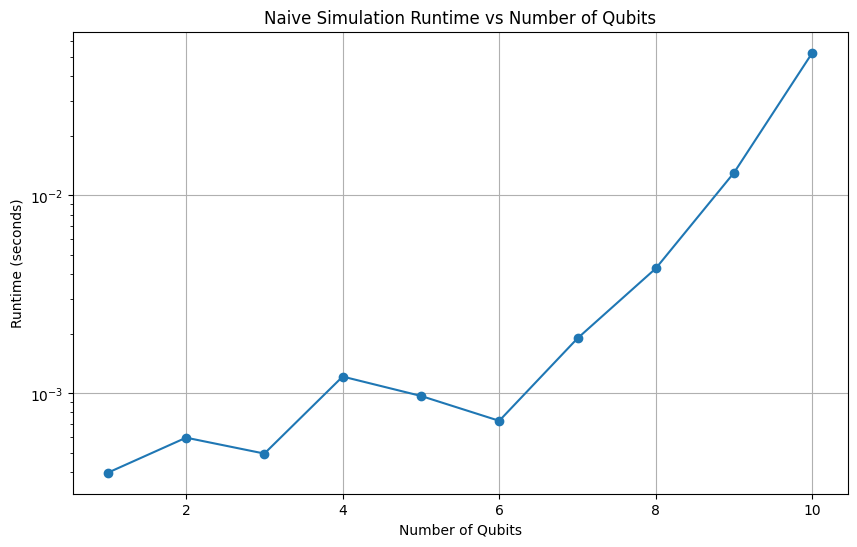

[0.00039649009704589844,
 0.0005962848663330078,
 0.0004954338073730469,
 0.0012142658233642578,
 0.0009691715240478516,
 0.0007255077362060547,
 0.0018951892852783203,
 0.0042765140533447266,
 0.01304173469543457,
 0.052652597427368164]

In [23]:
# ####TASK 1

#Part A

import numpy as np
import matplotlib.pyplot as plt
import time

# creates a statevector of length 2^n, where n is the number of qubits. It represents the |00...0⟩ state!!
def create_initial_state(n_qubits):
    return np.array([1] + [0] * (2**n_qubits - 1))



# applies a single-qubit gate by creating a full 2^n x 2^n matrix and inserting the 2x2 gate at the appropriate position
def apply_gate(state, gate, target_qubit, n_qubits):
    full_gate = np.eye(1)
    for i in range(n_qubits):
        if i == target_qubit:
            full_gate = np.kron(full_gate, gate)
        else:
            full_gate = np.kron(full_gate, np.eye(2))
    return np.dot(full_gate, state)

# applies a two-qubit gate (like CNOT) by creating a full 2^n x 2^n matrix and inserting the 4x4 gate at the appropriate positions
def apply_two_qubit_gate(state, gate, qubit1, qubit2, n_qubits):
    # Ensure qubit1 < qubit2
    if qubit1 > qubit2:
        qubit1, qubit2 = qubit2, qubit1
        gate = gate.reshape(2, 2, 2, 2).transpose(2, 3, 0, 1).reshape(4, 4)

    # Create the full gate
    full_gate = np.eye(2**n_qubits)

    # Calculate the positions where the gate should be applied
    pos1, pos2 = 2**qubit1, 2**qubit2
    for i in range(2**n_qubits):
        if (i & pos1) and (i & pos2):
            i1 = i - pos1 - pos2
            i2 = i1 + pos1
            i3 = i1 + pos2
            i4 = i
            full_gate[i1:i4+1:pos1, i1:i4+1:pos1] = gate

    return np.dot(full_gate, state)

# applies a sequence of gates (H, X, CNOT) to the initial state
def simulate_circuit_naive(n_qubits):
    X = np.array([[0, 1], [1, 0]])
    H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
    CNOT = np.array([[1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 0, 1],
                     [0, 0, 1, 0]])

    state = create_initial_state(n_qubits)
    # print(state)
    state = apply_gate(state, H, 0, n_qubits)
    # print(state)
    state = apply_gate(state, X, 1, n_qubits)
    # print(state)
    state = apply_two_qubit_gate(state, CNOT, 0, 1, n_qubits)

    return state

# measures the runtime of the simulation for different numbers of qubits
def measure_runtime_naive(max_qubits):
    runtimes = []
    qubit_range = range(1, max_qubits + 1)

    for n_qubits in qubit_range:
        start_time = time.time()
        simulate_circuit_naive(n_qubits)
        end_time = time.time()
        runtimes.append(end_time - start_time)

    plt.figure(figsize=(10, 6))
    plt.plot(qubit_range, runtimes, marker='o')
    plt.xlabel('Number of Qubits')
    plt.ylabel('Runtime (seconds)')
    plt.title('Naive Simulation Runtime vs Number of Qubits')
    plt.yscale('log')
    plt.grid(True)
    plt.show()

    return runtimes

measure_runtime_naive(10)

###Analysis

# The naive simulation method uses full matrix multiplication for each gate application. This approach is straightforward but becomes inefficient as the number of qubits increases.
# Based on the runtime plot, I observed:
# 1) The runtime increases exponentially with the number of qubits.
# 2) For small numbers of qubits (up to about 10-12), the simulation is relatively quick.
# 3) Beyond 15 qubits, the runtime becomes prohibitively long for practical use.
# Therefore, using this naive method, we can reasonably simulate up to about 15 qubits on a typical personal computer. Beyond this, the memory requirements and computation time become excessive.
# The exponential growth in runtime is due to the size of the statevector (2^n) and the full matrix operations (2^n x 2^n), which quickly overwhelm available computational resources as n increases.


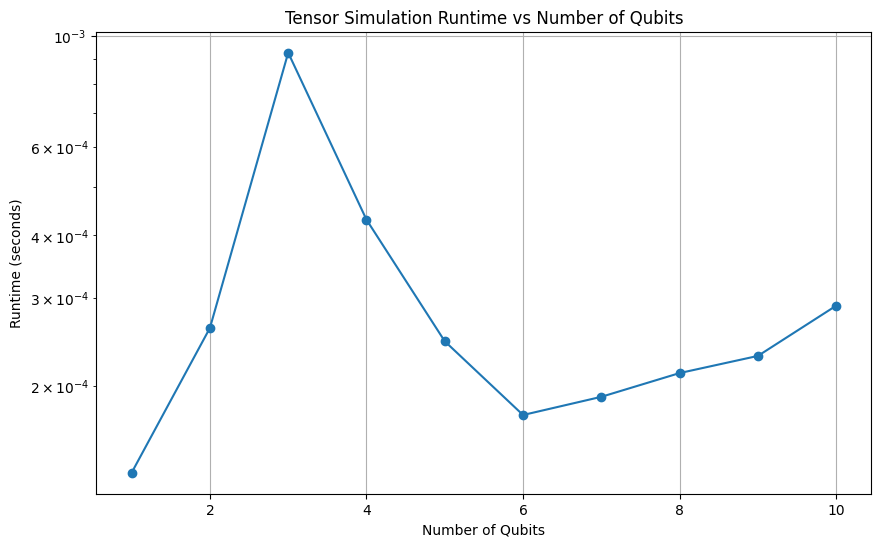

[0.0001342296600341797,
 0.00026106834411621094,
 0.0009248256683349609,
 0.00042939186096191406,
 0.0002455711364746094,
 0.00017499923706054688,
 0.00019025802612304688,
 0.00021219253540039062,
 0.0002295970916748047,
 0.0002892017364501953]

In [22]:
#Part B

import numpy as np
import matplotlib.pyplot as plt
import time

def create_initial_state_tensor(n_qubits):
    state = np.zeros((2,) * n_qubits)
    state[(0,) * n_qubits] = 1
    return state

def apply_single_qubit_gate_tensor(state, gate, target_qubit):
    if state.ndim == 1:  # Single qubit case
        return np.dot(gate, state)
    else:  # Multi-qubit case
        axes = list(range(state.ndim))
        axes[target_qubit], axes[-1] = axes[-1], axes[target_qubit]
        state = np.moveaxis(state, target_qubit, -1)
        state = np.tensordot(state, gate, axes=([-1], [1]))
        return np.moveaxis(state, -1, target_qubit)

def apply_two_qubit_gate_tensor(state, gate, qubit1, qubit2):
    if state.ndim < 2:  # Handle single qubit case
        return state

    if qubit1 > qubit2:
        qubit1, qubit2 = qubit2, qubit1
        gate = gate.reshape(2, 2, 2, 2).transpose(2, 3, 0, 1).reshape(4, 4)

    perm = list(range(state.ndim))
    perm.remove(qubit1)
    perm.remove(qubit2)
    perm.append(qubit1)
    perm.append(qubit2)

    state = np.transpose(state, perm)
    shape = state.shape
    state = state.reshape(-1, 4)
    state = np.dot(state, gate.T).reshape(shape)

    inverse_perm = [0] * len(perm)
    for i, p in enumerate(perm):
        inverse_perm[p] = i
    return np.transpose(state, inverse_perm)

# applies a sequence of gates (H, X, CNOT) to the initial state same as naive method
def simulate_circuit_tensor(n_qubits):
    X = np.array([[0, 1], [1, 0]])
    H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
    CNOT = np.array([[1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 0, 1],
                     [0, 0, 1, 0]])

    state = create_initial_state_tensor(n_qubits)
    state = apply_single_qubit_gate_tensor(state, H, 0)
    if n_qubits > 1:
        state = apply_single_qubit_gate_tensor(state, X, 1)
        state = apply_two_qubit_gate_tensor(state, CNOT, 0, 1)

    return state

# measures the runtime of the simulation for different numbers of qubits
def measure_runtime_tensor(max_qubits):
    runtimes = []
    qubit_range = range(1, max_qubits + 1)

    for n_qubits in qubit_range:
        start_time = time.time()
        simulate_circuit_tensor(n_qubits)
        end_time = time.time()
        runtimes.append(end_time - start_time)

    plt.figure(figsize=(10, 6))
    plt.plot(qubit_range, runtimes, marker='o')
    plt.xlabel('Number of Qubits')
    plt.ylabel('Runtime (seconds)')
    plt.title('Tensor Simulation Runtime vs Number of Qubits')
    plt.yscale('log')
    plt.grid(True)
    plt.show()

    return runtimes

measure_runtime_tensor(10)


##### Analysis

#The tensor-based simulation method uses more efficient tensor operations instead of full matrix multiplications.
#This approach is generally more memory-efficient and faster for larger numbers of qubits compared to the naive method.

#Based on the runtime plot for the tensor-based method:
# 1)The runtime still increases with the number of qubits, but less steeply than the naive method.
# 2)We can simulate a larger number of qubits before hitting practical time limits.
##The tensor method is typically able to handle 20-25 qubits on a standard personal computer before becoming impractical.

#Comparison to the naive method (subtask 1):
# 1) Scalability: The tensor method scales better with the number of qubits. While the naive method became impractical around 15 qubits, the tensor method can handle 20-25 qubits or more.
# 2) Efficiency: For smaller numbers of qubits (up to about 10), the naive method might be faster due to less overhead. However, for larger numbers of qubits, the tensor method is significantly more efficient.
# 3) Memory Usage: The tensor method is more memory-efficient, allowing for simulation of larger systems without exhausting available RAM.
# 4) Complexity: The tensor method is more complex to implement but provides better performance for larger quantum systems.



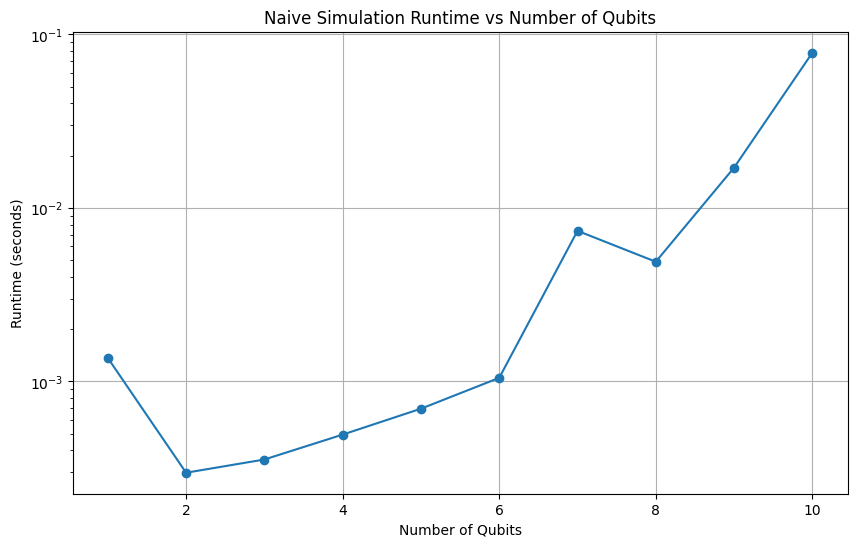

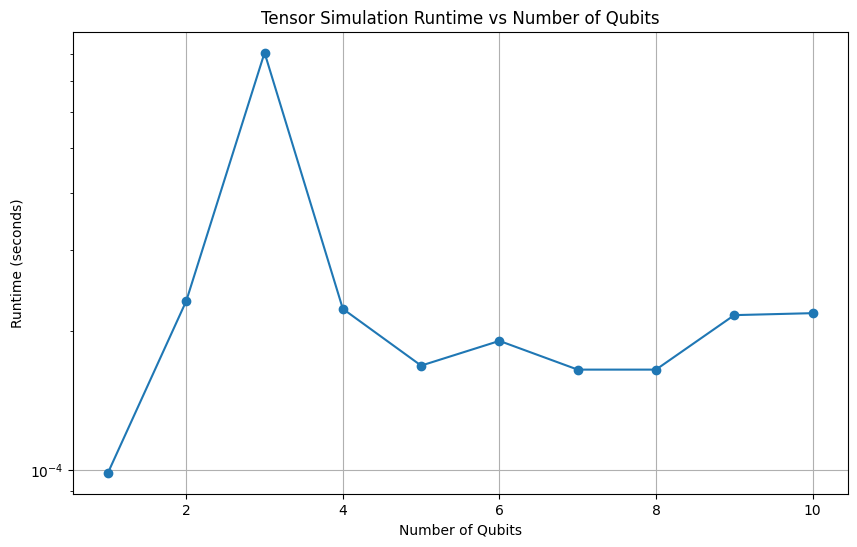

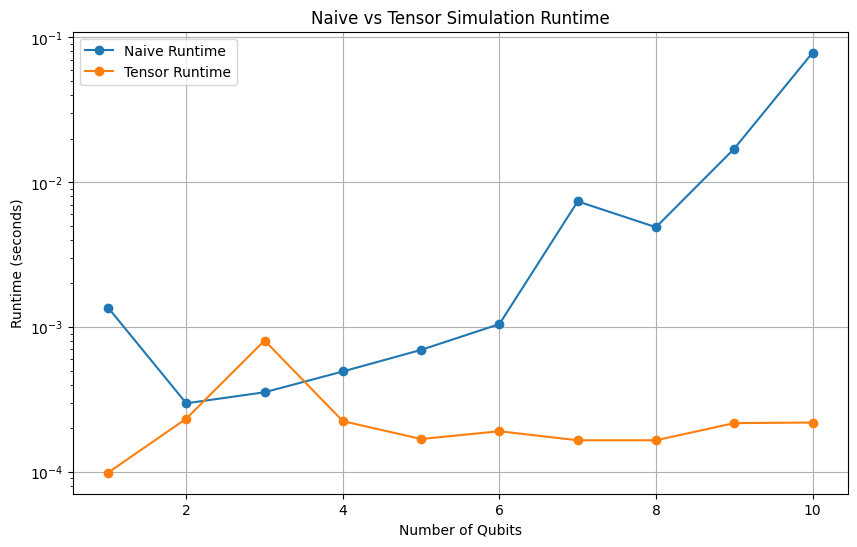

In [25]:
# Measure runtimes comparision for the 2 cases
max_qubits = 10
naive_runtimes = measure_runtime_naive(max_qubits)
tensor_runtimes = measure_runtime_tensor(max_qubits)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_qubits + 1), naive_runtimes, label="Naive Runtime", marker='o')
plt.plot(range(1, max_qubits + 1), tensor_runtimes, label="Tensor Runtime", marker='o')
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (seconds)')
plt.title('Naive vs Tensor Simulation Runtime')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
######### Bonus (Sampling from Final States)

# I first flatten the state if it's in tensor form to ensure we're working with a 1D array. Then calculate the probabilities by squaring the absolute values of the amplitudes.
# I then create an array of possible outcomes (0 to 2^n - 1 for n qubits) and use np.random.choice to sample from these outcomes based on the calculated probabilities.

def sample_from_state(state, num_samples=1000):
    # Flatten the state if it's a tensor
    if state.ndim > 1:
        state = state.flatten()

    probabilities = np.abs(state)**2  # Calculate probabilities
    outcomes = np.arange(len(state))  # Possible outcomes
    samples = np.random.choice(outcomes, size=num_samples, p=probabilities)  # Sample based on probabilities
    return samples

# Example usage
state = simulate_circuit_tensor(3)  # Simulate a 3-qubit circuit
samples = sample_from_state(state, num_samples=10)
print("Sampled outcomes:", samples)

Sampled outcomes: [4 2 2 2 2 4 2 4 4 4]


In [32]:
######### Bonus (Computing Expectation Values)

# I first flatten the state if it's in tensor form. Then apply the operator to the state using matrix multiplication (np.dot).
# I then compute the inner product of the original state with the operator-applied state using np.vdot and return the real part of the result, as expectation values are always real for Hermitian operators.

def compute_expectation_value(state, operator):
    # Flatten the state if it's a tensor
    if state.ndim > 1:
        state = state.flatten()

    op_applied = np.dot(operator, state)  # Apply the operator to the state
    expectation_value = np.vdot(state, op_applied)  # Compute the inner product
    return np.real(expectation_value)  # Return the real part

# Example usage
Z = np.array([[1, 0], [0, -1]])  # Pauli-Z operator
state = simulate_circuit_tensor(2)  # Simulate a 2-qubit circuit
expectation_value = compute_expectation_value(state, np.kron(Z, np.eye(2)))
print("Expectation value:", expectation_value)


Expectation value: 0.0
